# 패키지 설치

In [1]:
import copy
import pathlib
import random
from functools import reduce
from collections import defaultdict
import json
import pandas as pd
import numpy as np
from numpy import random

import matplotlib.pyplot as plt
import seaborn as sns

# 공간연산한 결과 데이터 표현하기 위한 패키지 
import folium
from folium import plugins
import shapely
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd
from IPython.display import display
from tqdm.notebook import tqdm
import sklearn.cluster
from geoband import API # API 부르기 
import pydeck as pdk
import os
from tqdm import notebook
import tqdm

import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="./data/NanumGothic-Regular.ttf").get_name()
rc('font', family=font_name)

from shapely.geometry import Polygon, Point
from numpy import random

#최적화 solver
import time
from mip import Model, xsum, maximize, BINARY  

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split
import pysal
import libpysal
from libpysal.weights import Queen, Rook, KNN, DistanceBand, Kernel
from esda.getisord import G
from esda.moran import Moran
from spreg import OLS, ML_Lag, ML_Error, GM_Lag, GM_Error, TSLS

warnings.filterwarnings("ignore")
%matplotlib inline

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:91: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Using Python-MIP package version 1.5.3


# 데이터 불러오기

In [2]:
# 노트북에서 만든 data_list load
file_df = pd.read_csv("./data/data_list.csv")

# order_num type change int to str
file_df["order_num"] = file_df["order_num"].apply(lambda x: str(x))

# 동적변수 데이터 할당
for idx in tqdm.tqdm(range(len(file_df) - 2)):
#     print(idx)
    file_name = ".".join(file_df.iloc[idx, :])
    globals()[f"df_{idx + 1}"] = gpd.read_file("./data/" + file_name)

100%|██████████| 32/32 [03:16<00:00,  6.15s/it]


In [3]:
# string to geometry
def str_to_geo(x):
    a = shapely.wkt.loads(x)
    return a

In [4]:
# data read
df_500 = pd.read_csv("./data/df_500_train.csv")
df_100_to_500 = pd.read_csv("./data/df_100_to_500_test.csv")
x_col = pd.read_csv("./data/x_col.csv").iloc[:,0].values
air = pd.read_csv("./data/air_quarter.csv")
df_100 = pd.read_csv("./data/df_100.csv")
road_geo = pd.read_csv("./data/road_transport.csv")


road_geo = gpd.GeoDataFrame(road_geo)
df_100 = gpd.GeoDataFrame(df_100)
df_500 = gpd.GeoDataFrame(df_500)
df_100_to_500 = gpd.GeoDataFrame(df_100_to_500)
air = gpd.GeoDataFrame(air)

In [5]:
# 데이터 타입 변경
df_100["geometry"] = df_100["geometry"].apply(lambda x: str_to_geo(x))
df_100["gid_center"] = df_100["gid_center"].apply(lambda x: str_to_geo(x))
df_100["gid_center"] = df_100["gid_center"].astype("geometry")
df_500["geometry"] = df_500["geometry"].apply(lambda x: str_to_geo(x))
air["geometry"] = gpd.points_from_xy(air.lon, air.lat)
road_geo["geometry"] = road_geo["geometry"].apply(lambda x: str_to_geo(x))

In [7]:
# 버퍼
coor_1m = (1/88.74/1000)
air["buffer"] = air["geometry"].buffer(coor_1m * 5000)

# 모델링

In [3]:
# modeling
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import r2_score

# 교차검증

In [8]:
# 교차검수 점수
def check_score(df, kfold, x_col, y_col, model):
    x = df[x_col]
    y = df[y_col]
    print("교차 검증 점수 : ", cross_val_score(model, x, y, cv = kfold))

In [9]:
# k-fold 교차검증으로 모델들의 r2_score 확인
# 음수값이 나올정도로 모델의 성능이 나쁘고 dataset이 작다보니깐 일반화도 잘되어 있지 않다.
lr_reg = LinearRegression()
sgd_reg = SGDRegressor(max_iter=300)
dtree_reg = DecisionTreeRegressor()
xgb_reg = XGBRegressor()
rf_reg = RandomForestRegressor()

kfold = KFold(n_splits=5)

models = [lr_reg, sgd_reg, dtree_reg, xgb_reg, rf_reg]
model_name = ["선형회귀", "경사하강", "결정트리", "xgboost", "랜덤포레스트"]

for idx, model in enumerate(models):
    print(model_name[idx], "교차검증 r2_score")
    check_score(df_500, kfold, x_col, "승하차건수", model)

선형회귀 교차검증 r2_score
교차 검증 점수 :  [ 0.31042448  0.19227914 -0.31126111  0.14292355  0.02374038]
경사하강 교차검증 r2_score
교차 검증 점수 :  [ 0.11972285  0.09700711 -0.53890756 -0.00963848 -0.07372173]
결정트리 교차검증 r2_score
교차 검증 점수 :  [-0.19714065 -0.19075267 -0.90642154 -0.13991434 -0.28205579]
xgboost 교차검증 r2_score
교차 검증 점수 :  [ 0.33540564  0.12553087 -0.27300311  0.26922981  0.11152836]
랜덤포레스트 교차검증 r2_score
교차 검증 점수 :  [ 0.42612117  0.22482537 -0.23615226  0.31370041  0.16497089]


In [10]:
col = np.append(x_col, "승하차건수")

<AxesSubplot:xlabel='공업시설', ylabel='승하차건수'>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


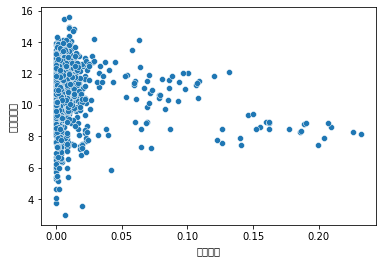

In [11]:
# 공업시설과 종속변수의 scatterplot
# 제거 고려 대상 승하차건수 < 10
# 공업시설 > 0.1
sns.scatterplot(x= df_500[x_col[0]], y= df_500["승하차건수"])

# 이상치 제거

In [12]:
# 제거대상
idx_1 = df_500[(df_500["승하차건수"] < 10.0) & (df_500["공업시설"] > 0.1)].index.values

<AxesSubplot:xlabel='문화체육시설', ylabel='승하차건수'>

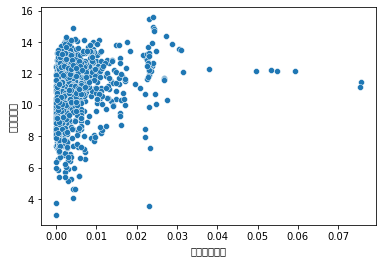

In [13]:
# 문화체육시설과 승하차건수
# 문화체육시설 
sns.scatterplot(x= df_500[x_col[1]], y= df_500["승하차건수"])

In [14]:
# 제거대상
idx_2 = df_500[(df_500["승하차건수"] < 4) & (df_500["문화체육시설"] > 0.02)].index.values

<AxesSubplot:xlabel='상업시설', ylabel='승하차건수'>

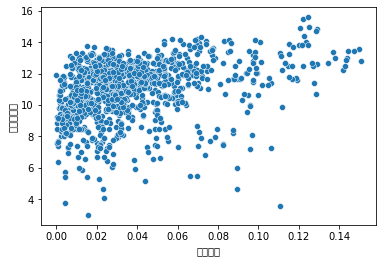

In [15]:
# 상업시설과 승하차건수
sns.scatterplot(x= df_500[x_col[2]], y= df_500["승하차건수"])

In [16]:
# 제거대상
idx_3 = df_500[(df_500["승하차건수"] < 4) & (df_500["상업시설"] > 0.1)].index.values

<AxesSubplot:xlabel='주거시설', ylabel='승하차건수'>

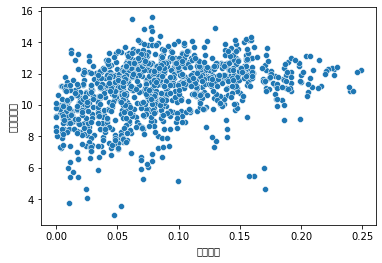

In [17]:
# 주거시설과 승하차건수
sns.scatterplot(x= df_500[x_col[3]], y= df_500["승하차건수"])

In [18]:
# 제거대상
idx_4 = df_500[(df_500["승하차건수"] < 6.5) & (df_500["주거시설"] > 0.15)].index.values

In [19]:
# 제거 index 병합
idx = np.concatenate([idx_1, idx_2, idx_3, idx_4])
# 중복 제거
idx = list(set(idx))

In [20]:
# 이상치 변수 제거 
df_500_drop = copy.deepcopy(df_500.drop(idx).reset_index(drop = True))

In [21]:
# 이상치 제거 후 변수
# 여전히 낮은 설명력
lr_reg = LinearRegression()
sgd_reg = SGDRegressor(max_iter=300)
dtree_reg = DecisionTreeRegressor()
xgb_reg = XGBRegressor()
rf_reg = RandomForestRegressor()

kfold = KFold(n_splits=5)

models = [lr_reg, sgd_reg, dtree_reg, xgb_reg, rf_reg]
model_name = ["선형회귀", "경사하강", "결정트리", "xgboost", "랜덤포레스트"]

for idx, model in enumerate(models):
    print(model_name[idx], "교차검증 r2_score")
    check_score(df_500_drop, kfold, x_col, "승하차건수", model)

선형회귀 교차검증 r2_score
교차 검증 점수 :  [ 0.25471787  0.10621498 -0.34677622  0.17364685  0.11823946]
경사하강 교차검증 r2_score
교차 검증 점수 :  [ 0.12396511  0.07179273 -0.54364212  0.01726677 -0.06303231]
결정트리 교차검증 r2_score
교차 검증 점수 :  [-0.11030512 -0.45322888 -1.11671503 -0.22488418 -0.10101795]
xgboost 교차검증 r2_score
교차 검증 점수 :  [ 0.31116512  0.06348691 -0.55413512  0.2835828   0.21332111]
랜덤포레스트 교차검증 r2_score
교차 검증 점수 :  [ 0.39092012  0.17601331 -0.2078521   0.33273847  0.29183662]


In [22]:
road_width = df_22.loc[:, ["link_id", "width"]]
road_width["link_id"] = road_width["link_id"].astype("int")

# 도로폭 추가 road df
road_geo_width = pd.merge(road_geo, road_width, how="left", on="link_id")

In [23]:
# air buffer
air_buffer = air.loc[:, ["center", "buffer"]].rename({"buffer":"geometry"}, axis = 1)
air_buffer = air_buffer.drop_duplicates().reset_index(drop = True)
air_buffer["buffer"] = air_buffer["geometry"]

In [ ]:
# air 시각화
style0 = {'fillColor': '#228B22', 'color': 'black', "opacity":"0.3", "fillOpacity":"0"}
style1 = {'fillColor': '#228B22', 'color': 'blue', "fillOpacity":"0","opacity":"0.3"}
style2 = {'fillColor': '#00FFFFFF', 'color': 'red', "fillOpacity":"0","opacity":"0.3"}
style3 = {'fillColor': '#00FFFFFF', 'color': 'red', "opacity":"0.5"}
m = folium.Map([37,127], zoom_start=7)

# df_100_0.crs = "epsg:4326"
air_buffer.crs = "epsg:4326"
df_100_to_500_point.crs = "epsg:4326"


m = folium.Map(max_bounds = True,
               zoom_start=12,
               location=[37.277896,127.016544])



# for idx in range(len(df_500)):
#     folium.vector_layers.Polygon(
#         locations = build_df.loc[idx, "geometry"]
#     ).add_to(m)

folium.GeoJson("./data/31.수원시_행정경계(읍면동).geojson", name="geojson", style_function = lambda x: style0).add_to(m)
folium.GeoJson(data = air_buffer.loc[:, "geometry"], style_function = lambda x:style1).add_to(m)
folium.GeoJson(data = df_100_to_500_point, style_function = lambda x:style2).add_to(m)
m

In [24]:
# gis 관련변수
df_100_crit = df_100.loc[:, ["gid", "geometry", "gid_center"]]

In [25]:
# gid 기준 병합
df_100_to_500 = df_100_to_500.drop_duplicates()
df_100_to_500_geo = pd.merge(df_100_to_500, df_100_crit, how = "left", on = "gid")

In [26]:
# gid geometry 변수 추가
df_100_to_500_point = df_100_to_500_geo.loc[:, ["gid", "gid_center"]].rename({"gid_center":"geometry"}, axis = 1)
df_100_to_500_point = gpd.GeoDataFrame(df_100_to_500_point)

In [27]:
# sjoin 시에 gid_center 변수 살리기위해
df_100_to_500_point["gid_center"] = df_100_to_500_point["geometry"]

In [28]:
# 관측소버퍼와 gid위치 contains
air_df_100_to_500_geo = gpd.sjoin(air_buffer, df_100_to_500_point, op="contains")

# 관측소 위치와 gid 위치 거리 구하기
air_df_100_to_500_geo["distance"] = 0
air_df_100_to_500_geo["distance"] = (air_df_100_to_500_geo["buffer"].centroid).distance(air_df_100_to_500_geo["gid_center"])

In [29]:
# gid별 distance 정렬
air_df_100_t = air_df_100_to_500_geo.sort_values(["gid", "distance"]).reset_index(drop = True)

# 최소값 index 추출
idx = air_df_100_t.loc[:, ["gid", "gid_center"]].drop_duplicates(keep = "first").index

# center명과 gid 명 추출
air_crit = air_df_100_t.iloc[idx, :].reset_index(drop = True).loc[:, ["center", "gid"]]

# df_100_to_500_geo에 관측소 center명 추가
df_100_to_500_geo_center = pd.merge(df_100_to_500_geo, air_crit, how= "left", on="gid")

In [31]:
# 분기별 관측소 평균 CAI 확인
# 1분기 평균으로 정한다.# 가장 미세먼지가 심한 분기로 필터링
for i in range(1, 5):
    print(f"{i}분기 CAI 값")
    print(air[air["분기"] == i].groupby("center")["CAI"].agg("mean").sort_values())
    print("\n")

1분기 CAI 값
center
호매실동     81.087719
영통동      92.324112
광교동      92.460414
고색동     101.231894
천천동     101.661718
신풍동     102.179712
인계동     106.771705
동수원     116.132029
Name: CAI, dtype: float64


2분기 CAI 값
center
고색동     61.153137
신풍동     66.300922
천천동     66.434285
인계동     67.037615
광교동     67.775201
호매실동    69.517544
영통동     69.763158
동수원     70.833333
Name: CAI, dtype: float64


3분기 CAI 값
center
고색동     49.555556
인계동     49.968877
광교동     50.466102
동수원     50.503831
천천동     51.215631
신풍동     52.628011
호매실동    54.116959
영통동     59.247696
Name: CAI, dtype: float64


4분기 CAI 값
center
광교동     63.285239
영통동     66.903509
신풍동     67.763158
천천동     68.614035
인계동     72.061404
호매실동    72.236842
고색동     72.447368
동수원     75.062008
Name: CAI, dtype: float64




In [32]:
# CAI 평균 
air_cai = air.groupby("center")["CAI"].agg("mean").sort_values().reset_index()
# air_cai["CAI_num"] = pd.cut(air_cai["CAI"], 5, labels = range(1, 6))

# air_cai["CAI_num"] = air_cai["CAI_num"].astype("int")

In [185]:
# 교통량과 CAI변수의 상관분석
# center의 위치와 읍면동 위치로 병합하기 위해
# ..1동은 ..동으로 바꾸는 함수
# 참고 : center가 직접 위치해 있는 동만 바꿈
def re_emd(x):
    if x == '광교1동' or x == '광교1동':
        a = '광교동'
    elif x == '영통1동' or x == '영통2동' or x == '영통3동':
        a = '영통동'
    else:
        a = x
    return a

# 함수적용
road_geo_width["읍면동명"] = road_geo_width["읍면동명"].apply(lambda x: re_emd(x))

# 교통량 관련 변수 추출
col = road_geo_width.iloc[:, 7: -3].columns.values
# 읍면동명으로 그룹화 후 교통량 관련 변수 평균
cor_df = road_geo_width.groupby("읍면동명")[col].agg("mean").reset_index()

# 병합 후 상관분석
pd.merge(cor_df, air_cai, left_on="읍면동명", right_on="center").corr()

# 전체 추정교통량과 CAI는 상관계수가 높으므로 교통량 변수들은 사용안하고 CAI 변수만 지수산출에 사용

,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량,혼잡시간강도,혼잡빈도강도,CAI
전체_추정교통량,1.000000,0.996440,0.446278,0.840272,0.772217,0.677878,0.722738
승용차_추정교통량,0.996440,1.000000,0.387620,0.792300,0.754324,0.651497,0.777402
버스_추정교통량,0.446278,0.387620,1.000000,0.679990,0.822922,0.891792,-0.212613
화물차_추정교통량,0.840272,0.792300,0.679990,1.000000,0.686178,0.656172,0.257400
혼잡시간강도,0.772217,0.754324,0.822922,0.686178,1.000000,0.987724,0.357513
혼잡빈도강도,0.677878,0.651497,0.891792,0.656172,0.987724,1.000000,0.209421
CAI,0.722738,0.777402,-0.212613,0.257400,0.357513,0.209421,1.000000


In [33]:
df_100_to_500_geo_center_cai = pd.merge(df_100_to_500_geo_center, air_cai, how = "left", on="center")

In [34]:
final_x_col = np.append(x_col, "CAI")
final_x_col = np.delete(x_col)

In [48]:
# final_X_col 지수 부여
num_lst = []
for col in final_x_col:
    # 공업시설은 계수가 음수이기 때문에 낮은 값일수록 높은 점수 부여
    if col == "공업시설":
        num_col = col + "_num"
        num_lst.append(num_col)
        cut_5 = pd.cut(df_100_to_500_geo_center_cai[col], 5, labels = range(5, 0, -1))
        df_100_to_500_geo_center_cai[num_col] = cut_5
        df_100_to_500_geo_center_cai[num_col] = df_100_to_500_geo_center_cai[num_col].astype("int")
        
    else:
        num_col = col + "_num"
        num_lst.append(num_col)
        cut_5 = pd.cut(df_100_to_500_geo_center_cai[col], 5, labels = range(1, 6))
        df_100_to_500_geo_center_cai[num_col] = cut_5
        df_100_to_500_geo_center_cai[num_col] = df_100_to_500_geo_center_cai[num_col].astype("int")

In [50]:
# 최종지수
check_num = df_100_to_500_geo_center_cai.loc[:, num_lst].sum(axis = 1)
df_100_to_500_geo_center_cai["check_num"] = check_num
df_100_to_500_geo_center_cai = gpd.GeoDataFrame(df_100_to_500_geo_center_cai)

In [51]:
# 격자 road sjoin 뽑기
a = gpd.sjoin(df_100_to_500_geo_center_cai[["gid", "geometry"]], df_26, how = "inner")

In [52]:
# 스마트 정류장의 세로가 2.5m이고 보행자 통해공간 폭인 1.5m 이상 확보 되야 되므로
# 인도의 폭은 4m 이상을 만족해야 된다.
# 인도를 포함한 격자 데이터 중 4m이상의 인도 폭을 가진 gid 추출
road_gid = a[a["WIDT"] >= 4]["gid"].unique()

In [53]:
# road_gid 필터링
df_100_to_500_geo_center_cai_road = df_100_to_500_geo_center_cai.set_index("gid").loc[road_gid, :].reset_index()

In [54]:
# bus 변수 추출
bus_df = df_500.loc[:, :"geometry"]

In [55]:
# df_100_to_500 변수에
final_df_bus = gpd.sjoin(df_100_to_500_geo_center_cai_road, bus_df, how = "left", op = "contains")

# 대표 버스정류장 추출

In [ ]:
# 1. 100m 격자내에 버스정류장이 속한 격자추출
final_df_bus_out = final_df_bus[final_df_bus["정류장ID"].isnull()].reset_index(drop = True)
final_df_bus_in = final_df_bus[final_df_bus["정류장ID"].notnull()].reset_index(drop = True)

In [57]:
# 2. BIS 설치여부로 필터링
final_df_bus_in_bis = final_df_bus_in[final_df_bus_in["BIS설치여부"] == 1.0].reset_index(drop = True)

In [58]:
# 3. 100m 격자의 중심과의 거리와 가장 가까운 정류장
final_df_bus_in_bis["bus_center"] = gpd.points_from_xy(final_df_bus_in_bis.lon, final_df_bus_in_bis.lat)
final_df_bus_in_bis["distance"] = final_df_bus_in_bis["gid_center"].distance(final_df_bus_in_bis["bus_center"])

idx = final_df_bus_in_bis.sort_values(by = ["gid", "distance"])[["gid", "old"]].drop_duplicates(keep = "first").index.values
final_df_bus_in_bis_dist = final_df_bus_in_bis.iloc[idx, :].reset_index(drop = True)

In [59]:
# 최종 df 
real_final_df = pd.concat([final_df_bus_out, final_df_bus_in_bis_dist]).reset_index(drop = True)
real_final_df.to_csv("./data/real_final_df.csv", index = False)

# 광고 타켓팅 선정

In [ ]:
# 광고 마케팅 target
max_data = real_final_df.iloc[:, 6:18].max(axis = 1).values
ad_col = real_final_df.iloc[:, 6:18].columns.values
copy_df = copy.deepcopy(real_final_df.iloc[:, 6:18])
copy_df["ad_target"] = 0


for idx in range(len(copy_df)):
    index = np.where(real_final_df.iloc[idx, 6:18] == max_data[idx])[0]
    col = ad_col[index]
    copy_df.loc[idx, "ad_target"] = col[0]

In [61]:
# real_final_df ad_target 변수 추가
real_final_df["ad_target"] = copy_df["ad_target"]

In [62]:
# 최종 df save
real_final_df.to_csv("./data/real_final_df.csv", index = False)

In [63]:
# 시각화 작업
df_plot = real_final_df.sort_values(by = "check_num", ascending = False).head(30).reset_index(drop = True)

In [64]:
df_plot_bus = df_plot[df_plot["lon"].notnull()].reset_index(drop = True)

In [65]:
df_plot_bus_geo = df_plot_bus[["gid", "bus_center"]].rename({"bus_center":"geometry"}, axis = 1)

In [66]:
df_plot_bus_geo = gpd.GeoDataFrame(df_plot_bus_geo)

In [ ]:
# air 시각화
style0 = {'fillColor': '#228B22', 'color': 'black', "opacity":"0.3", "fillOpacity":"0"}
style1 = {'fillColor': '#228B22', 'color': 'blue', "fillOpacity":"0","opacity":"1"}
style2 = {'fillColor': '#00FFFFFF', 'color': 'red', "fillOpacity":"0","opacity":"1"}
style3 = {'fillColor': '#00FFFFFF', 'color': 'red', "opacity":"0.5"}
m = folium.Map([37,127], zoom_start=7)

# df_100_0.crs = "epsg:4326"
df_plot.crs = "epsg:4326"
df_plot_bus_geo.crs = "epsg:4326"
df_500.crs = "epsg:4326"
road_geo.crs = "epsg:4326"

m = folium.Map(max_bounds = True,
               zoom_start=12,
               location=[37.277896,127.016544])



# for idx in range(len(df_500)):
#     folium.vector_layers.Polygon(
#         locations = build_df.loc[idx, "geometry"]
#     ).add_to(m)

folium.GeoJson("./data/31.수원시_행정경계(읍면동).geojson", name="geojson", style_function = lambda x: style0).add_to(m)
folium.GeoJson(data = df_plot.loc[:, "geometry"], style_function = lambda x:style1).add_to(m)
folium.GeoJson(data = df_plot_bus_geo.loc[:, "geometry"], style_function = lambda x:style2).add_to(m)
folium.GeoJson(data = road_geo.loc[:, "geometry"], style_function = lambda x:style3).add_to(m)
m

## 최종 입지 결과

In [121]:
# 우선적으로 버스 정류장을 포함한 
re_check = real_final_df[real_final_df["check_num"] >= 22].sort_values(by = "check_num",
                                                                      ascending = False).reset_index(drop = True)

In [122]:
re_check_bus_out = re_check[re_check["정류장ID"].isnull()].reset_index(drop = True)
re_check_bus_in = re_check[re_check["정류장ID"].notnull()].reset_index(drop = True)

In [223]:
re_check_bus_out_head = re_check_bus_out.sort_values(by = ["문화체육시설", "상업시설", "주거시설", "주차장수"], ascending = False).head(12)

In [224]:
re_final_df = pd.concat([re_check_bus_in, re_check_bus_out_head]).reset_index(drop = True)

In [225]:
re_check_bus_in_plot = re_check_bus_in[["gid", "bus_center"]].rename({"bus_center":"geometry"}, axis = 1)
re_check_bus_in_plot = gpd.GeoDataFrame(re_check_bus_in_plot)

In [ ]:
# air 시각화
style0 = {'fillColor': '#228B22', 'color': 'black', "opacity":"0.3", "fillOpacity":"0"}
style1 = {'fillColor': '#228B22', 'color': 'blue', "fillOpacity":"0","opacity":"1"}
style2 = {'fillColor': '#00FFFFFF', 'color': 'red', "fillOpacity":"0","opacity":"1"}
style3 = {'fillColor': '#00FFFFFF', 'color': 'red', "opacity":"0.5"}
m = folium.Map([37,127], zoom_start=7)

# df_100_0.crs = "epsg:4326"
re_final_df.crs = "epsg:4326"
re_check_bus_in_plot.crs = "epsg:4326"
road_geo.crs = "epsg:4326"

m = folium.Map(max_bounds = True,
               zoom_start=12,
               location=[37.277896,127.016544])



# for idx in range(len(df_500)):
#     folium.vector_layers.Polygon(
#         locations = build_df.loc[idx, "geometry"]
#     ).add_to(m)

folium.GeoJson("./data/31.수원시_행정경계(읍면동).geojson", name="geojson", style_function = lambda x: style0).add_to(m)
folium.GeoJson(data = re_final_df.loc[:, "geometry"], style_function = lambda x:style1).add_to(m)
folium.GeoJson(data = re_check_bus_in_plot.loc[:, "geometry"], style_function = lambda x:style2).add_to(m)
folium.GeoJson(data = road_geo.loc[:, "geometry"], style_function = lambda x:style3).add_to(m)
m

In [227]:
re_final_df["r주거시설"] = re_final_df["주거시설"] / re_final_df["주거시설"].max()

def multipolygon_to_coordinates(x):
    lon, lat = x[0].exterior.xy
    return [[x, y] for x, y in zip(lon, lat)]

re_final_df['coordinates'] = re_final_df['geometry'].apply(multipolygon_to_coordinates)
# del df['geometry']

In [ ]:
# pydeck 시각화
# Make layer
layer1 = pdk.Layer( 'PolygonLayer', # 사용할 Layer 타입 
                  re_final_df[["gid", "coordinates"]], # 시각화에 쓰일 데이터프레임 
                  get_polygon='coordinates', # geometry 정보를 담고있는 컬럼 이름 
                  get_fill_color='[227, 255, 227, 80]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
                  pickable=True, # 지도와 interactive 한 동작 on 
                  auto_highlight=True # 마우스 오버(hover) 시 박스 출력 
                 ) 

layer2 = pdk.Layer( 'PolygonLayer', # 사용할 Layer 타입 
                  re_final_df[["gid", "r주거시설", "coordinates"]], # 시각화에 쓰일 데이터프레임 
                  get_polygon='coordinates', # geometry 정보를 담고있는 컬럼 이름 
                  get_fill_color='[255*r주거시설,200,227, 1000*r주거시설]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
                  pickable=True, # 지도와 interactive 한 동작 on 
                  auto_highlight=True # 마우스 오버(hover) 시 박스 출력 
                 ) 

# Set the viewport location 
center = [127.016544,37.277896] # 오산시 중심
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=11
) 

# Render 
r = pdk.Deck(layers=[layer1, layer2], initial_view_state=view_state,
             mapbox_key = "pk.eyJ1IjoiamNsYXJhODExIiwiYSI6ImNrZzF4bWNhdTBpNnEydG54dGpxNDEwajAifQ.XWxOKQ-2HqFBVBYa-XoS-g"
            )

r.to_html()

In [232]:
re_final_df.to_csv("./data/bus_30.csv", index = False)